In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults, load_all_results
from utils.referral_handler import ReferralHandler, ReferralResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from plotting.main_seg_results import plot_seg_erros_uncertainties
from plotting.result_plots import plot_referral_results
from plotting.entropy_map_plots import plot_entropy_map_for_patient
from plotting.result_plots import plot_referral_results

from utils.dslices.exper_handler import ExperHandlerEnsemble

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 1

exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])


exp_mc01_softdice = {3: "20180630_10_26_32_dcnn_mc_f3p01_150KE_lr2e02",
                    2: "20180630_10_27_07_dcnn_mc_f2p01_150KE_lr2e02",
                    1: "20180629_11_28_29_dcnn_mc_f1p01_150KE_lr2e02",
                    0: "20180629_10_33_08_dcnn_mc_f0p01_150KE_lr2e02"}
exp_mc01_softdice_path = os.path.join(LOG_DIR, exp_mc01_softdice[TEST_FOLD])

exp_mc01_crossent = {3: "20180703_18_15_22_dcnn_mc_f3p01_entrpy_150KE_lr2e02",
                     2: "20180703_18_11_10_dcnn_mc_f2p01_entrpy_150KE_lr2e02",
                     1: "20180703_18_13_51_dcnn_mc_f1p01_entrpy_150KE_lr2e02",
                     0: "20180703_18_09_33_dcnn_mc_f0p01_entrpy_150KE_lr2e02"}
exp_mc01_crossent_path = os.path.join(LOG_DIR, exp_mc01_crossent[TEST_FOLD])

exper_hdl_mc01_brier = ExperimentHandler()
exper_hdl_mc01_brier.load_experiment(exp_mc01_brier_path, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_brier.model_name))
print("-------------------------------------------------------------------------")

exper_hdl_mc01_softdice = ExperimentHandler()
exper_hdl_mc01_softdice.load_experiment(exp_mc01_softdice_path, use_logfile=False)
exper_hdl_mc01_softdice.set_root_dir(ROOT_DIR)
exper_hdl_mc01_softdice.set_model_name("MC-dropout soft-dice fold-{} (p={})".format(
                                exper_hdl_mc01_softdice.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_softdice.exper.run_args.drop_prob))
# make sure we correct spelling for softdice to soft-dice, which we use in figures
exper_hdl_mc01_softdice.exper.run_args.loss_function = "soft-dice"
print("Model name: {}".format(exper_hdl_mc01_softdice.model_name))
print("-------------------------------------------------------------------------")

exper_hdl_mc01_crossent = ExperimentHandler()
exper_hdl_mc01_crossent.load_experiment(exp_mc01_crossent_path, use_logfile=False)
exper_hdl_mc01_crossent.set_root_dir(ROOT_DIR)
exper_hdl_mc01_crossent.set_model_name("MC-dropout cross-entropy fold-{} (p={})".format(
                                exper_hdl_mc01_crossent.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_crossent.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_crossent.model_name))
print("-------------------------------------------------------------------------")

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=1 loss=brier
-------------------------------------------------------------------------
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180629_11_28_29_dcnn_mc_f1p01_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=1 loss=softdice
-------------------------------------------------------------------------
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180703_18_13_51_dcnn_mc_f1p01_entrpy_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=1 loss=cross-entropy
-------------------------------------------------------------------------


In [3]:
# exper_hdl.exper.run_args.fold_ids
exper_hdl = exper_hdl_mc01_brier
dataset = ACDC2017DataSet(exper_hdl.exper.config, search_mask=config.dflt_image_name + ".mhd",
                              fold_ids=[1], preprocess=False,
                              debug=exper_hdl.exper.run_args.quick_run, do_augment=False,
                              incomplete_only=False)

  3%|▎         | 2/75 [00:00<00:04, 15.71it/s]

INFO - Using folds [1] - busy loading images/references...this may take a while!
INFO - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold1/train/images_iso/*patient*.mhd <<<


100%|██████████| 25/25 [00:01<00:00, 24.95it/s]

INFO - Using folds [1] - loaded 200 files: 75 studies in train set, 25 studies in validation set
INFO - Mean width/height/#slices per image 235/263/9
---------------------- Image incompleteness statistics -------------------------
ES: slices missing RV/MYO/LV 0/0/0 (0.00/0.00/0.00) / complete 0 wo-all 0
ED: slices missing RV/MYO/LV 0/0/0 (0.00/0.00/0.00) / complete 0 wo-all 0


In [5]:
from in_out.dataset_slice_detector import create_dataset

seg_exper_dict = ExperHandlerEnsemble(exp_mc01_brier)

detect_dataset = create_dataset(dataset, seg_exper_dict, type_of_map="u_map", degenerate_type="mean", 
                                pos_label=1)
del seg_exper_dict

  0%|          | 0/100 [00:00<?, ?it/s]

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier
INFO - Loading referral results for thresholds [0.001]


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]

INFO - Total degenerate over ES/ED and train/test set 15.39% / 8.25%
 --- 
INFO - ES - train data-set stats: total 666.0 / degenerate 21.02 % / 11.86 %
INFO - ED - train data-set stats: total 666.0 / degenerate 10.36 % / 5.26 %
INFO - ES - test data-set stats: total 237.0 / degenerate 19.41 % / 10.13 %
INFO - ED - test data-set stats: total 237.0 / degenerate 9.70 % / 4.64 %
INFO - Patients with degenerate slices train/test 70.0 / 24.0


In [19]:
img, lbl, extra_lbl = detect_dataset.get("patient087", is_train=True)
img['deg_slices'].shape

(3, 3, 264, 190)

In [26]:
new_batch = BatchHandlerSD(data_set=detect_dataset, is_train=False, cuda=False)

Current patient ID patient011
(18, 3, 229, 271)


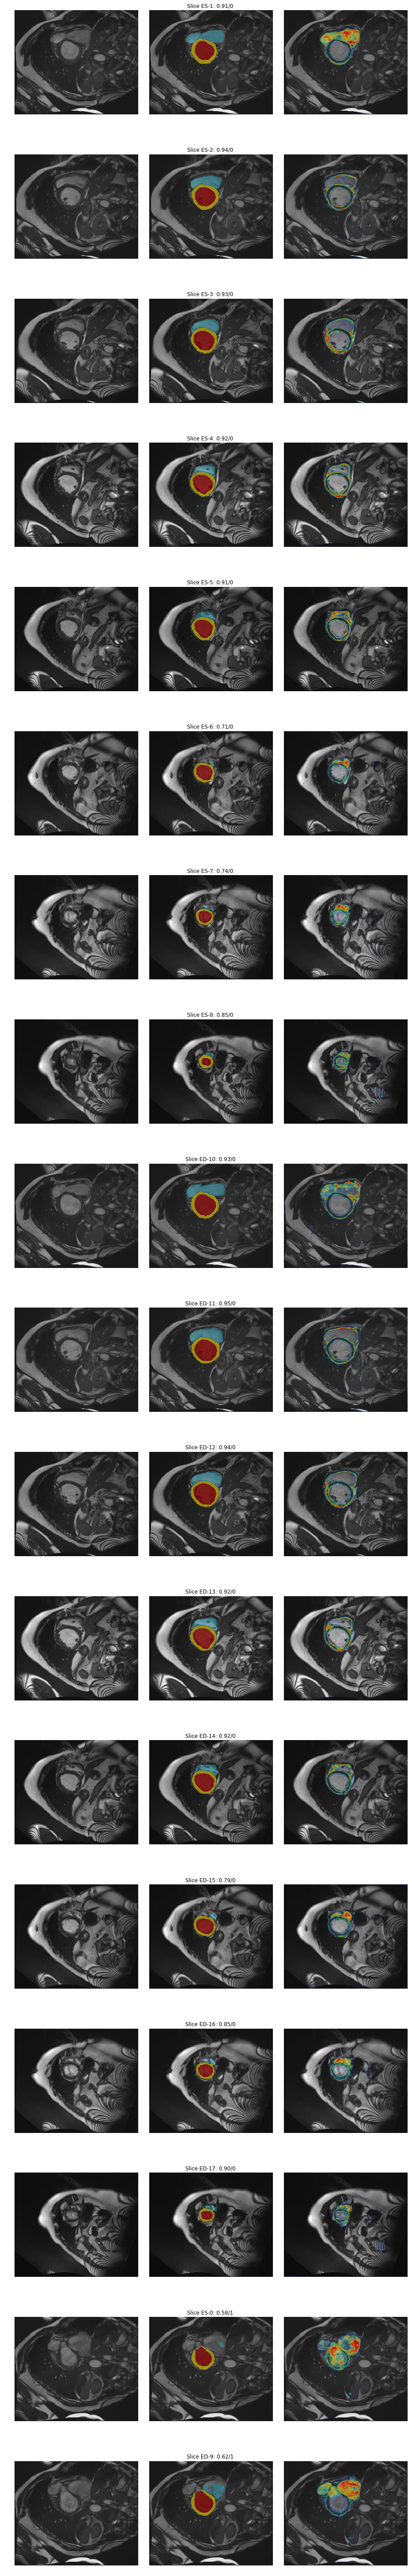

In [27]:
from utils.dslices.batch_handler import BatchHandler as BatchHandlerSD


def transparent_cmap(cmap, N=255):
        "Copy colormap and set alpha values"
        mycmap = cmap
        mycmap._init()
        mycmap._lut[:, -1] = np.linspace(0, 0.8, N + 4)
        return mycmap

mycmap = transparent_cmap(plt.get_cmap('jet'))
batch_size = 8

x_input, y_lbl, y_extra_lbl = new_batch(batch_size=None, backward_freq=1, patient_id=None,
                                        do_balance=False)

if batch_size is None or batch_size != x_input.shape[0]:
    batch_size = x_input.shape[0]
x_input = x_input.numpy()
y_lbl = y_lbl.numpy()
print("Current patient ID {}".format(new_batch.current_patient_id))
print(x_input.shape)
if batch_size is None:
    batch_size = x_input.shape[0]
    print("WARNING - setting batch size to {}".format(batch_size))
rows = batch_size * 2
columns = 6
height = 3 * rows
width = 16

fig = plt.figure(figsize=(width, height))
row = 0

# rotate stuff
# x_input = np.rot90(x_input, k=2, axes=(2,3))

for b in np.arange(batch_size):
    img_slice = x_input[b, 0]
    seg_mask = x_input[b, 1]
    u_map = x_input[b, 2]
    slice_id = int(y_extra_lbl[b, 1])
    phase = "ES" if int(y_extra_lbl[b, 0]) == 0 else "ED"
    dice_slice = y_extra_lbl[b, 2]
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    ax1.imshow(img_slice, cmap=cm.gray)
    plt.axis("off")
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(img_slice, cmap=cm.gray)
    ax2.set_title("Slice {}-{}: {:.2f}/{} ".format(phase, slice_id, dice_slice, y_lbl[b]))
    ax2.imshow(seg_mask, cmap=cm.jet)
    plt.axis("off")
    ax3 = plt.subplot2grid((rows, columns), (row, 4), rowspan=2, colspan=2)
    ax3.imshow(img_slice, cmap=cm.gray)
    ax3_plot = ax3.imshow(u_map, cmap=mycmap)
    plt.axis("off")
    
    
    plt.axis("off")
    row += 2

    